# Neighborhood Recommender

The following model has the objective of recommend a neighborhood where to live in Mexico City considering two main factors: Distance from the workplace and the type of venues preference.

The model assumes that the user is planning his relocation to Mexico City. In this scenario, the user knows the rent level he is willing to pay, what are the offices, College, or any place of interest where the user will be commuting to frequently in Mexico Citye, and also knows the type of venues he'd like to have around his new home in Mexico City. Based on this, all of this information is filled to the model to find the top 10 neighborhoods that are the closest according to user's data.

## 1 Import geo and rent data

Neighborhoods' geolocation data was gathered from https://datos.cdmx.gob.mx/explore/dataset/coloniascdmx/export/ 
Average rent cost per neighborhood was gathered from https://propiedades.com/valores/19-de-mayo-df/departamentos-renta considering as search parameters: Rent, Apartment, DF / CDMX, Neighborhood

All the information, geolocation and rent cost per neighborhood, was consolidated in the MX_Neighborhoods_Geo_Rent.csv file

In [3]:
# The code was removed by Watson Studio for sharing.

,Municipality,Neighborhood,Neighborhood_Municipality,Latitude,Longitude,Rent
0,BENITO JUAREZ,ACACIAS,"ACACIAS, BENITO JUAREZ",19.364106,-99.174065,18822
1,BENITO JUAREZ,ACTIPAN,"ACTIPAN, BENITO JUAREZ",19.369882,-99.178167,17707
2,BENITO JUAREZ,ALAMOS I,"ALAMOS I, BENITO JUAREZ",19.400430,-99.140929,11413
3,BENITO JUAREZ,ALAMOS II,"ALAMOS II, BENITO JUAREZ",19.394901,-99.142231,11413
4,BENITO JUAREZ,ALBERT,"ALBERT, BENITO JUAREZ",19.370574,-99.139390,11258


In [5]:
# Install components required

import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f30e5a795f8>]],
      dtype=object)

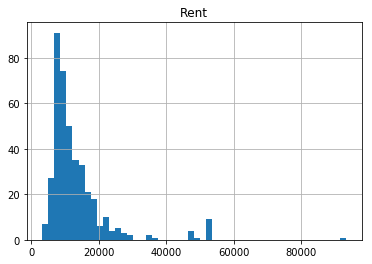

In [6]:
# Histogram to analyse rent cost distribution

df_cdmx.hist(column='Rent', bins=50)

## 2 Get user's data

Data requested to users is:

a) Office where you will work in Mexico City - We are using "IBM, Mexico city" in this example

b) Top 5 venue preferences that the user wants around her home in Mexico City - Type of venues should be provided in order of preference, we are using for this example:

    1 - Coffee Shop
    2 - Japanese Restaurant
    3 - Gym / Fitness Center
    4 - Mexican Restaurant
    5 - Park

c) Rent cost willing to pay in Mexico City in Mexican Pesos - $15,000 Mexican pesos for this example

In [9]:
# Install Mominatim to get the geolocation information of User's office in Mexico City

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [10]:
# IBM, Mexico City it's been used in this example as the work place were the user will be working in Mexico City

user_office = 'IBM, Mexico city'

geolocator = Nominatim(user_agent="office_explorer")
location = geolocator.geocode(user_office)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of users office are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of users office are 19.37187335, -99.26118151812653.


In [11]:
# Get user's data and check data types

user_data = {'1st Most Common Venue':['Coffee Shop'], '2nd Most Common Venue':['Japanese Restaurant'], '3rd Most Common Venue':['Gym / Fitness Center'], '4th Most Common Venue':['Mexican Restaurant'], '5th Most Common Venue':['Park'], 'Rent':['15000']} 
  
# Create DataFrame 
df_user = pd.DataFrame(user_data) 
  
df_user.dtypes

1st Most Common Venue    object
2nd Most Common Venue    object
3rd Most Common Venue    object
4th Most Common Venue    object
5th Most Common Venue    object
Rent                     object
dtype: object

In [12]:
# Change Rent to integer

df_user.Rent = df_user.Rent.astype('int64')
df_user.dtypes

1st Most Common Venue    object
2nd Most Common Venue    object
3rd Most Common Venue    object
4th Most Common Venue    object
5th Most Common Venue    object
Rent                      int64
dtype: object

In [13]:
# Add geolocation data of the users's office to the other user information

df_user['Latitude'] = latitude
df_user['Longitude'] = longitude
df_user.head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Rent,Latitude,Longitude
0,Coffee Shop,Japanese Restaurant,Gym / Fitness Center,Mexican Restaurant,Park,15000,19.371873,-99.261182


In [14]:
# Calculate a rent range considering a 20% of variation

x = df_user['Rent']
x_rent = x.values[0]
a = x_rent * 1.2
b = x_rent - (x_rent * 0.2)
print(b, " to ", a)

12000.0  to  18000.0


In [15]:
# Create a new dataframe to filter data based on the rent range defined

df_cdmx_filtered = df_cdmx.copy()
df_cdmx_filtered.head(20)

,Municipality,Neighborhood,Neighborhood_Municipality,Latitude,Longitude,Rent
0,BENITO JUAREZ,ACACIAS,"ACACIAS, BENITO JUAREZ",19.364106,-99.174065,18822
1,BENITO JUAREZ,ACTIPAN,"ACTIPAN, BENITO JUAREZ",19.369882,-99.178167,17707
2,BENITO JUAREZ,ALAMOS I,"ALAMOS I, BENITO JUAREZ",19.400430,-99.140929,11413
3,BENITO JUAREZ,ALAMOS II,"ALAMOS II, BENITO JUAREZ",19.394901,-99.142231,11413
4,BENITO JUAREZ,ALBERT,"ALBERT, BENITO JUAREZ",19.370574,-99.139390,11258
5,BENITO JUAREZ,AMERICAS UNIDAS-DEL LAGO,"AMERICAS UNIDAS-DEL LAGO, BENITO JUAREZ",19.381855,-99.141677,10094
6,BENITO JUAREZ,ATENOR SALAS,"ATENOR SALAS, BENITO JUAREZ",19.403145,-99.147862,8956
7,BENITO JUAREZ,CENTRO URBANO PRESIDENTE ALEMAN U HAB,"CENTRO URBANO PRESIDENTE ALEMAN (U HAB), BENIT...",19.370971,-99.172077,11805
8,BENITO JUAREZ,CIUDAD DE LOS DEPORTES,"CIUDAD DE LOS DEPORTES, BENITO JUAREZ",19.383390,-99.180064,15804
9,BENITO JUAREZ,CREDITO CONSTRUCTOR,"CREDITO CONSTRUCTOR, BENITO JUAREZ",19.364934,-99.180323,23610


In [16]:
# Filter data based on rent range

df_cdmx_filtered = df_cdmx_filtered.query("Rent > @b & Rent < @a") #Filter
df_cdmx_filtered = df_cdmx_filtered.reset_index(drop=True) #Reset index
df_cdmx_filtered.head()

,Municipality,Neighborhood,Neighborhood_Municipality,Latitude,Longitude,Rent
0,BENITO JUAREZ,ACTIPAN,"ACTIPAN, BENITO JUAREZ",19.369882,-99.178167,17707
1,BENITO JUAREZ,CIUDAD DE LOS DEPORTES,"CIUDAD DE LOS DEPORTES, BENITO JUAREZ",19.383390,-99.180064,15804
2,BENITO JUAREZ,EXTREMADURA INSURGENTES,"EXTREMADURA INSURGENTES, BENITO JUAREZ",19.377035,-99.179869,17609
3,BENITO JUAREZ,GENERAL PEDRO MARIA ANAYA,"GENERAL PEDRO MARIA ANAYA, BENITO JUAREZ",19.360482,-99.158773,16375
4,BENITO JUAREZ,INDEPENDENCIA,"INDEPENDENCIA, BENITO JUAREZ",19.379773,-99.148095,12409


## 3 Get venues data per neighborhood

For this part, the Foursquare api, endpoint explore is used

In [17]:
# Install components required to handle JSON files

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [18]:
# The code was removed by Watson Studio for sharing.

In [19]:
# Test the connection to Foursquare passing just the first neighborhood

df_cdmx_filtered.loc[0, 'Neighborhood']

'ACTIPAN'

In [20]:
# Saving in variables neighborhood Lat and Long

neighborhood_latitude = df_cdmx_filtered.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_cdmx_filtered.loc[0, 'Longitude'] # neighborhood longitude value
neighborhood_name = df_cdmx_filtered.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of ACTIPAN are 19.36988192, -99.17816705.


In [21]:
# Create the URL to access Foursquare

LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # redius around the neighborhood to explore

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
# url # display URL

In [22]:
# Get venues around test neighborhood - explore endpoint

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ee94383f55e2f54f165e6cb'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Actipan',
  'headerFullLocation': 'Actipan, Mexico City',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 114,
  'suggestedBounds': {'ne': {'lat': 19.374381924500007,
    'lng': -99.17340595594162},
   'sw': {'lat': 19.365381915499995, 'lng': -99.18292814405838}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '598ce75bf0b49078f26eaf74',
       'name': 'Puro Amor',
       'location': {'lat': 19.369499,
        'lng': -99.176386,
        'labeledLatLngs': [{'label': 'display',
          'lat': 19.369499,
          'lng': -99.176386}],
        'distance': 

In [23]:
# Function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [24]:
# Create dataframe with json data

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Puro Amor,Vegetarian / Vegan Restaurant,19.369499,-99.176386
1,Johnny Rockets,Burger Joint,19.371168,-99.178445
2,Build-A-Bear Workshop,Toy / Game Store,19.371380,-99.179353
3,Cambalache,Argentinian Restaurant,19.371139,-99.179760
4,Tacos Miguel De Pechuga,Taco Place,19.370888,-99.176567


In [29]:
# Function to get near venues for all neighborhoods

def getNearbyVenues(names, latitudes, longitudes, radius=500):
        
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [31]:
# Create dataframe with venues information

cdmx_venues = getNearbyVenues(names=df_cdmx_filtered['Neighborhood'],
                                   latitudes=df_cdmx_filtered['Latitude'],
                                   longitudes=df_cdmx_filtered['Longitude']
                                  )

ACTIPAN
CIUDAD DE LOS DEPORTES
EXTREMADURA INSURGENTES
GENERAL PEDRO MARIA ANAYA
INDEPENDENCIA
INSURGENTES SAN BORJA
LETRAN VALLE
MERCED GOMEZ
MIRAVALLE
MIXCOAC
NARVARTE I
NARVARTE II
NARVARTE III
NARVARTE IV
NARVARTE V
NARVARTE VI
NOCHE BUENA
NONOALCO
OCHO DE AGOSTO
PIEDAD NARVARTE
PORTALES I
PORTALES II
PORTALES III
PORTALES IV
RESIDENCIAL EMPERADORES
SAN JUAN
SAN PEDRO DE LOS  PINOS
VERTIZ NARVARTE
ALTILLO COND ALTILLO UNIVERSIDAD
ATLANTIDA
BOSQUES DE TETLAMEYA
CAMPESTRE COYOACAN FRACC
CANTIL DEL PEDREGAL
CIUDAD JARDIN
COPILCO EL BAJO
COPILCO UNIVERSIDAD
COUNTRY CLUB
CUADRANTE DE SAN FRANCISCO
DE LA CANDELARIA PBLO
DEL CARMEN
DEL NIÑO JESUS BARR
EL CARACOL
EL PARQUE DE COYOACAN FRACC
EL RELOJ
EL ROSEDAL I
EL ROSEDAL II
EX EJIDO DE CHURUBUSCO
EX HACIENDA COAPA
HERMOSILLO
INSURGENTES CUICUILCO
INTEGRACION LATINOAMERICANA U HAB
JOYAS DEL PEDREGAL FRACC
LA CANTERA U HAB
LA CONCEPCION BARR
LOS REYES PBLO
LOS SAUCES FRACC
OLIMPICA
OXTOPULCO UNIVERSIDAD
PARQUE SAN ANDRES
PEDREGAL DE LA ZOR

In [32]:
# Check dataframe with venues information

print(cdmx_venues.shape)
cdmx_venues.head(10)

(4485, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ACTIPAN,19.369882,-99.178167,Puro Amor,19.369499,-99.176386,Vegetarian / Vegan Restaurant
1,ACTIPAN,19.369882,-99.178167,Johnny Rockets,19.371168,-99.178445,Burger Joint
2,ACTIPAN,19.369882,-99.178167,Build-A-Bear Workshop,19.371380,-99.179353,Toy / Game Store
3,ACTIPAN,19.369882,-99.178167,Cambalache,19.371139,-99.179760,Argentinian Restaurant
4,ACTIPAN,19.369882,-99.178167,Tacos Miguel De Pechuga,19.370888,-99.176567,Taco Place
5,ACTIPAN,19.369882,-99.178167,Latente Café,19.367725,-99.177624,Café
6,ACTIPAN,19.369882,-99.178167,London Squash,19.370946,-99.177144,Other Great Outdoors
7,ACTIPAN,19.369882,-99.178167,Little Caesars Pizza,19.371043,-99.177300,Pizza Place
8,ACTIPAN,19.369882,-99.178167,The Body Shop,19.371382,-99.179503,Cosmetics Shop
9,ACTIPAN,19.369882,-99.178167,Academia Bartec,19.370023,-99.178688,Dance Studio


In [33]:
# Group by neighborhood and count the number of venues

cdmx_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
ACTIPAN,100,100,100,100,100,100
ALGARIN,21,21,21,21,21,21
ALTILLO COND ALTILLO UNIVERSIDAD,17,17,17,17,17,17
ANAHUAC DOS LAGOS,39,39,39,39,39,39
ANAHUAC II,75,75,75,75,75,75
ANAHUAC LAGO NORTE,22,22,22,22,22,22
ANAHUAC LAGO SUR,16,16,16,16,16,16
ANAHUAC MARIANO ESCOBEDO,60,60,60,60,60,60
ATLANTIDA,59,59,59,59,59,59


In [34]:
# Count the total number of unique categories

print('There are {} uniques categories.'.format(len(cdmx_venues['Venue Category'].unique())))

There are 310 uniques categories.


In [35]:
# Perform one hot encoding

cdmx_onehot = pd.get_dummies(cdmx_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cdmx_onehot['Neighborhood'] = cdmx_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [cdmx_onehot.columns[-1]] + list(cdmx_onehot.columns[:-1])
cdmx_onehot = cdmx_onehot[fixed_columns]

# get a list of columns
cols = list(cdmx_onehot)
# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('Neighborhood')))
cols
# use ix to reorder
cdmx_onehot = cdmx_onehot.ix[:, cols]

cdmx_onehot.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,Neighborhood,Yoga Studio,Accessories Store,Advertising Agency,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Venezuelan Restaurant,Veterinarian,Video Game Store,Volleyball Court,Water Park,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store
0,ACTIPAN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ACTIPAN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ACTIPAN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ACTIPAN,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,ACTIPAN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# Check the shape of dataframe to check how more columns were added due to the one hot encoding

cdmx_onehot.shape

(4485, 310)

In [37]:
# Group by neighborhood taking the mean of frequency of each category

cdmx_grouped = cdmx_onehot.groupby('Neighborhood').mean().reset_index()
cdmx_grouped

,Neighborhood,Yoga Studio,Accessories Store,Advertising Agency,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Venezuelan Restaurant,Veterinarian,Video Game Store,Volleyball Court,Water Park,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store
0,ACTIPAN,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.030000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.010000,0.000000
1,ALGARIN,0.000000,0.000000,0.047619,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,ALTILLO COND ALTILLO UNIVERSIDAD,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.058824,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.058824
3,ANAHUAC DOS LAGOS,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.025641,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,ANAHUAC II,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.013333,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.013333,0.000000
5,ANAHUAC LAGO NORTE,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
6,ANAHUAC LAGO SUR,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
7,ANAHUAC MARIANO ESCOBEDO,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.016667,0.016667,...,0.016667,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.016667,0.000000
8,ATLANTIDA,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.016949,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
9,BOSQUES DE TETLAMEYA,0.000000,0.029412,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000


In [38]:
# Check the shape of dataframe after grouping

cdmx_grouped.shape

(100, 310)

In [39]:
# Print each neighborhood along with the top 5 most common venues

num_top_venues = 5

for hood in cdmx_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = cdmx_grouped[cdmx_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ACTIPAN----
                    venue  freq
0             Coffee Shop  0.08
1          Cosmetics Shop  0.05
2    Gym / Fitness Center  0.04
3  Argentinian Restaurant  0.03
4                    Café  0.03


----ALGARIN----
                venue  freq
0          Taco Place  0.19
1  Mexican Restaurant  0.19
2              Bakery  0.10
3        Dance Studio  0.05
4             Brewery  0.05


----ALTILLO COND ALTILLO UNIVERSIDAD----
            venue  freq
0  Cosmetics Shop  0.18
1   Women's Store  0.06
2      University  0.06
3            Park  0.06
4     Coffee Shop  0.06


----ANAHUAC DOS LAGOS----
                venue  freq
0  Mexican Restaurant  0.13
1   Convenience Store  0.08
2                 Gym  0.05
3          Restaurant  0.05
4        Burger Joint  0.05


----ANAHUAC II----
                venue  freq
0  Mexican Restaurant  0.19
1          Taco Place  0.08
2         Coffee Shop  0.07
3   Convenience Store  0.04
4                 Gym  0.04


----ANAHUAC LAGO NORTE----
     

In [40]:
# Function to sort the venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [41]:
# Create a dataframe

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = cdmx_grouped['Neighborhood']

for ind in np.arange(cdmx_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cdmx_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(20)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,ACTIPAN,Coffee Shop,Cosmetics Shop,Gym / Fitness Center,Toy / Game Store,Health & Beauty Service
1,ALGARIN,Taco Place,Mexican Restaurant,Bakery,Bed & Breakfast,Coffee Shop
2,ALTILLO COND ALTILLO UNIVERSIDAD,Cosmetics Shop,Bookstore,Health & Beauty Service,Japanese Restaurant,Jewelry Store
3,ANAHUAC DOS LAGOS,Mexican Restaurant,Convenience Store,Gym,Restaurant,Burger Joint
4,ANAHUAC II,Mexican Restaurant,Taco Place,Coffee Shop,Gym,Restaurant
5,ANAHUAC LAGO NORTE,Mexican Restaurant,Taco Place,Burger Joint,Gym,Restaurant
6,ANAHUAC LAGO SUR,Taco Place,Mexican Restaurant,Café,Skate Park,Burger Joint
7,ANAHUAC MARIANO ESCOBEDO,Restaurant,Mexican Restaurant,Coffee Shop,Taco Place,Bar
8,ATLANTIDA,Mexican Restaurant,Taco Place,Restaurant,Convenience Store,Gym / Fitness Center
9,BOSQUES DE TETLAMEYA,Soccer Field,Soccer Stadium,Convenience Store,Coffee Shop,Park


In [42]:
# New dataframe including the top 5 venues and rent cost

cdmx_merged = df_cdmx_filtered

# merge cdmx_grouped with cdmx_data to add latitude/longitude for each neighborhood
cdmx_merged = cdmx_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

cdmx_merged.head(20)

,Municipality,Neighborhood,Neighborhood_Municipality,Latitude,Longitude,Rent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,BENITO JUAREZ,ACTIPAN,"ACTIPAN, BENITO JUAREZ",19.369882,-99.178167,17707,Coffee Shop,Cosmetics Shop,Gym / Fitness Center,Toy / Game Store,Health & Beauty Service
1,BENITO JUAREZ,CIUDAD DE LOS DEPORTES,"CIUDAD DE LOS DEPORTES, BENITO JUAREZ",19.383390,-99.180064,15804,Taco Place,Mexican Restaurant,Seafood Restaurant,Restaurant,Bakery
2,BENITO JUAREZ,EXTREMADURA INSURGENTES,"EXTREMADURA INSURGENTES, BENITO JUAREZ",19.377035,-99.179869,17609,Taco Place,Café,Park,Ice Cream Shop,Mexican Restaurant
3,BENITO JUAREZ,GENERAL PEDRO MARIA ANAYA,"GENERAL PEDRO MARIA ANAYA, BENITO JUAREZ",19.360482,-99.158773,16375,Taco Place,Pool,Restaurant,Gym,Convenience Store
4,BENITO JUAREZ,INDEPENDENCIA,"INDEPENDENCIA, BENITO JUAREZ",19.379773,-99.148095,12409,Mexican Restaurant,Taco Place,Coffee Shop,Steakhouse,Restaurant
5,BENITO JUAREZ,INSURGENTES SAN BORJA,"INSURGENTES SAN BORJA, BENITO JUAREZ",19.383526,-99.174046,17204,Taco Place,Mexican Restaurant,Restaurant,Spa,Seafood Restaurant
6,BENITO JUAREZ,LETRAN VALLE,"LETRAN VALLE, BENITO JUAREZ",19.376132,-99.155067,16625,Taco Place,Mexican Restaurant,Café,Ice Cream Shop,Food Truck
7,BENITO JUAREZ,MERCED GOMEZ,"MERCED GOMEZ, BENITO JUAREZ",19.365642,-99.189928,15802,Taco Place,Mexican Restaurant,Coffee Shop,Bakery,Ice Cream Shop
8,BENITO JUAREZ,MIRAVALLE,"MIRAVALLE, BENITO JUAREZ",19.361304,-99.141089,13280,Mexican Restaurant,Convenience Store,Gym / Fitness Center,Taco Place,Restaurant
9,BENITO JUAREZ,MIXCOAC,"MIXCOAC, BENITO JUAREZ",19.372884,-99.190003,14264,Mexican Restaurant,Taco Place,Bar,Food Truck,Pharmacy


In [43]:
# In order to calculate the distance among user's venue preferences and venues around each neighborhood, it is required to encode all venues information
# To encode venues information, the first step is to combine the venues preferences gathered from the user with venues information related to each neighborhood, all of this in a single dataframe

cdmx_merged_user = cdmx_merged.append(df_user, ignore_index = True)
cdmx_merged_user

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Latitude,Longitude,Municipality,Neighborhood,Neighborhood_Municipality,Rent
0,Coffee Shop,Cosmetics Shop,Gym / Fitness Center,Toy / Game Store,Health & Beauty Service,19.369882,-99.178167,BENITO JUAREZ,ACTIPAN,"ACTIPAN, BENITO JUAREZ",17707
1,Taco Place,Mexican Restaurant,Seafood Restaurant,Restaurant,Bakery,19.383390,-99.180064,BENITO JUAREZ,CIUDAD DE LOS DEPORTES,"CIUDAD DE LOS DEPORTES, BENITO JUAREZ",15804
2,Taco Place,Café,Park,Ice Cream Shop,Mexican Restaurant,19.377035,-99.179869,BENITO JUAREZ,EXTREMADURA INSURGENTES,"EXTREMADURA INSURGENTES, BENITO JUAREZ",17609
3,Taco Place,Pool,Restaurant,Gym,Convenience Store,19.360482,-99.158773,BENITO JUAREZ,GENERAL PEDRO MARIA ANAYA,"GENERAL PEDRO MARIA ANAYA, BENITO JUAREZ",16375
4,Mexican Restaurant,Taco Place,Coffee Shop,Steakhouse,Restaurant,19.379773,-99.148095,BENITO JUAREZ,INDEPENDENCIA,"INDEPENDENCIA, BENITO JUAREZ",12409
5,Taco Place,Mexican Restaurant,Restaurant,Spa,Seafood Restaurant,19.383526,-99.174046,BENITO JUAREZ,INSURGENTES SAN BORJA,"INSURGENTES SAN BORJA, BENITO JUAREZ",17204
6,Taco Place,Mexican Restaurant,Café,Ice Cream Shop,Food Truck,19.376132,-99.155067,BENITO JUAREZ,LETRAN VALLE,"LETRAN VALLE, BENITO JUAREZ",16625
7,Taco Place,Mexican Restaurant,Coffee Shop,Bakery,Ice Cream Shop,19.365642,-99.189928,BENITO JUAREZ,MERCED GOMEZ,"MERCED GOMEZ, BENITO JUAREZ",15802
8,Mexican Restaurant,Convenience Store,Gym / Fitness Center,Taco Place,Restaurant,19.361304,-99.141089,BENITO JUAREZ,MIRAVALLE,"MIRAVALLE, BENITO JUAREZ",13280
9,Mexican Restaurant,Taco Place,Bar,Food Truck,Pharmacy,19.372884,-99.190003,BENITO JUAREZ,MIXCOAC,"MIXCOAC, BENITO JUAREZ",14264


In [44]:
# Check shape and data types

print(cdmx_merged_user.shape)
print(cdmx_merged_user.dtypes)

(101, 11)
1st Most Common Venue         object
2nd Most Common Venue         object
3rd Most Common Venue         object
4th Most Common Venue         object
5th Most Common Venue         object
Latitude                     float64
Longitude                    float64
Municipality                  object
Neighborhood                  object
Neighborhood_Municipality     object
Rent                           int64
dtype: object


In [45]:
# Convert all type of venues into numerical codes

cols = ['1st Most Common Venue','2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue']
cdmx_merged_user[cols] = (pd.factorize(cdmx_merged_user[cols].values.ravel())[0]+1).reshape(-1, len(cols))
cdmx_merged_user.tail() #The last row correspond to the user's type of venues preferences

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Latitude,Longitude,Municipality,Neighborhood,Neighborhood_Municipality,Rent
96,7,8,10,26,6,19.466850,-99.209995,MIGUEL HIDALGO,SAN LORENZO TLALTENANGO,"SAN LORENZO TLALTENANGO, MIGUEL HIDALGO",13502
97,7,83,40,9,6,19.414857,-99.190416,MIGUEL HIDALGO,SAN MIGUEL CHAPULTEPEC I,"SAN MIGUEL CHAPULTEPEC I, MIGUEL HIDALGO",15740
98,33,1,9,6,11,19.411903,-99.183752,MIGUEL HIDALGO,SAN MIGUEL CHAPULTEPEC II,"SAN MIGUEL CHAPULTEPEC II, MIGUEL HIDALGO",17215
99,7,11,8,5,86,19.436411,-99.174458,MIGUEL HIDALGO,VERONICA ANZURES,"VERONICA ANZURES, MIGUEL HIDALGO",17920
100,1,35,3,7,12,19.371873,-99.261182,NaN,NaN,NaN,15000


In [46]:
# Check data types after encoding

cdmx_merged_user.dtypes

1st Most Common Venue          int64
2nd Most Common Venue          int64
3rd Most Common Venue          int64
4th Most Common Venue          int64
5th Most Common Venue          int64
Latitude                     float64
Longitude                    float64
Municipality                  object
Neighborhood                  object
Neighborhood_Municipality     object
Rent                           int64
dtype: object

In [47]:
# Create a new dataframe containing only the user preferences encoded

df_user_complete = cdmx_merged_user.copy()
df_user_complete.drop(df_user_complete.index[0:100], axis=0, inplace=True)

In [48]:
# Check data types before performing distance calculation

df_user_complete.dtypes

1st Most Common Venue          int64
2nd Most Common Venue          int64
3rd Most Common Venue          int64
4th Most Common Venue          int64
5th Most Common Venue          int64
Latitude                     float64
Longitude                    float64
Municipality                  object
Neighborhood                  object
Neighborhood_Municipality     object
Rent                           int64
dtype: object

## 4 Calculate total distance

In [49]:
# Calculate the Euclidean distance between user data and neighborhoods data. In order to do this, all variables are considered, geolocation data and type of venues

def Euclidean_Dist(df_user_complete, cdmx_merged_user, cols=['Latitude','Longitude', '1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue']):
    return np.linalg.norm(df_user_complete[cols].values - cdmx_merged_user[cols].values,
                   axis=1)

In [61]:
# Save the overall distance into a new column in the dataset

cdmx_merged_user['Total_Distance'] = Euclidean_Dist(df_user_complete, cdmx_merged_user)
cdmx_merged_user = cdmx_merged_user.dropna()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [62]:
# Sort ascending to get the closest neighborhoods on top of the list

cdmx_merged_user.sort_values(by=['Total_Distance'], ascending=True, inplace=True) # Sort
cdmx_merged_user = cdmx_merged_user.reset_index(drop=True) # Reset index after sorting
cdmx_merged_user.head(20)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Latitude,Longitude,Municipality,Neighborhood,Neighborhood_Municipality,Rent,Total_Distance
0,7,30,6,8,10,19.318273,-99.140971,COYOACAN,EL RELOJ,"EL RELOJ, COYOACAN",16724,8.661254
1,7,39,12,1,3,19.303854,-99.116520,COYOACAN,LOS SAUCES FRACC,"LOS SAUCES (FRACC), COYOACAN",13566,15.812196
2,6,23,7,21,10,19.386893,-99.150385,BENITO JUAREZ,NARVARTE VI,"NARVARTE VI, BENITO JUAREZ",16086,19.621735
3,7,50,6,10,1,19.438571,-99.164694,CUAUHTEMOC,SAN RAFAEL II,"SAN RAFAEL II, CUAUHTEMOC",13280,20.000344
4,7,16,3,6,9,19.361304,-99.141089,BENITO JUAREZ,MIRAVALLE,"MIRAVALLE, BENITO JUAREZ",13280,20.174601
5,7,39,9,28,6,19.333980,-99.174506,COYOACAN,LA CANTERA U HAB,"LA CANTERA (U HAB), COYOACAN",13463,23.769917
6,6,16,11,7,1,19.351901,-99.148280,COYOACAN,SAN MATEO BARR,"SAN MATEO (BARR), COYOACAN",13019,23.895881
7,6,14,9,15,16,19.360482,-99.158773,BENITO JUAREZ,GENERAL PEDRO MARIA ANAYA,"GENERAL PEDRO MARIA ANAYA, BENITO JUAREZ",16375,24.124896
8,7,12,6,11,15,19.310159,-99.135407,COYOACAN,EX HACIENDA COAPA,"EX HACIENDA COAPA, COYOACAN",15740,24.474877
9,7,16,15,9,23,19.443488,-99.189469,MIGUEL HIDALGO,ANAHUAC DOS LAGOS,"ANAHUAC DOS LAGOS, MIGUEL HIDALGO",12023,25.807175


In [66]:
# Replace numerical values of venues variables with the original text description

df_final = cdmx_merged_user
df_final = df_final.drop(['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue', 'Latitude', 'Longitude', 'Municipality', 'Neighborhood_Municipality', 'Rent'], axis=1)

# merge cdmx_grouped with cdmx_data to add latitude/longitude for each neighborhood
df_final = df_final.join(cdmx_merged.set_index('Neighborhood'), on='Neighborhood')

df_final.head(20)

,Neighborhood,Total_Distance,Municipality,Neighborhood_Municipality,Latitude,Longitude,Rent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,EL RELOJ,8.661254,COYOACAN,"EL RELOJ, COYOACAN",19.318273,-99.140971,16724,Mexican Restaurant,Soccer Field,Taco Place,Seafood Restaurant,Bakery
1,LOS SAUCES FRACC,15.812196,COYOACAN,"LOS SAUCES (FRACC), COYOACAN",19.303854,-99.116520,13566,Mexican Restaurant,Pizza Place,Park,Coffee Shop,Gym / Fitness Center
2,NARVARTE VI,19.621735,BENITO JUAREZ,"NARVARTE VI, BENITO JUAREZ",19.386893,-99.150385,16086,Taco Place,Burger Joint,Mexican Restaurant,Pharmacy,Bakery
3,SAN RAFAEL II,20.000344,CUAUHTEMOC,"SAN RAFAEL II, CUAUHTEMOC",19.438571,-99.164694,13280,Mexican Restaurant,Theater,Taco Place,Bakery,Coffee Shop
4,MIRAVALLE,20.174601,BENITO JUAREZ,"MIRAVALLE, BENITO JUAREZ",19.361304,-99.141089,13280,Mexican Restaurant,Convenience Store,Gym / Fitness Center,Taco Place,Restaurant
5,LA CANTERA U HAB,23.769917,COYOACAN,"LA CANTERA (U HAB), COYOACAN",19.333980,-99.174506,13463,Mexican Restaurant,Pizza Place,Restaurant,Creperie,Taco Place
6,SAN MATEO BARR,23.895881,COYOACAN,"SAN MATEO (BARR), COYOACAN",19.351901,-99.148280,13019,Taco Place,Convenience Store,Café,Mexican Restaurant,Coffee Shop
7,GENERAL PEDRO MARIA ANAYA,24.124896,BENITO JUAREZ,"GENERAL PEDRO MARIA ANAYA, BENITO JUAREZ",19.360482,-99.158773,16375,Taco Place,Pool,Restaurant,Gym,Convenience Store
8,EX HACIENDA COAPA,24.474877,COYOACAN,"EX HACIENDA COAPA, COYOACAN",19.310159,-99.135407,15740,Mexican Restaurant,Park,Taco Place,Café,Gym
9,ANAHUAC DOS LAGOS,25.807175,MIGUEL HIDALGO,"ANAHUAC DOS LAGOS, MIGUEL HIDALGO",19.443488,-99.189469,12023,Mexican Restaurant,Convenience Store,Gym,Restaurant,Burger Joint


In [68]:
# Create a new dataframe with the top 10 neighborhoods - Neighborhoods to recommend to the user

df_top10 = df_final.copy()
df_top10.drop(df_top10.index[10:], axis=0, inplace=True)
df_top10

,Neighborhood,Total_Distance,Municipality,Neighborhood_Municipality,Latitude,Longitude,Rent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,EL RELOJ,8.661254,COYOACAN,"EL RELOJ, COYOACAN",19.318273,-99.140971,16724,Mexican Restaurant,Soccer Field,Taco Place,Seafood Restaurant,Bakery
1,LOS SAUCES FRACC,15.812196,COYOACAN,"LOS SAUCES (FRACC), COYOACAN",19.303854,-99.116520,13566,Mexican Restaurant,Pizza Place,Park,Coffee Shop,Gym / Fitness Center
2,NARVARTE VI,19.621735,BENITO JUAREZ,"NARVARTE VI, BENITO JUAREZ",19.386893,-99.150385,16086,Taco Place,Burger Joint,Mexican Restaurant,Pharmacy,Bakery
3,SAN RAFAEL II,20.000344,CUAUHTEMOC,"SAN RAFAEL II, CUAUHTEMOC",19.438571,-99.164694,13280,Mexican Restaurant,Theater,Taco Place,Bakery,Coffee Shop
4,MIRAVALLE,20.174601,BENITO JUAREZ,"MIRAVALLE, BENITO JUAREZ",19.361304,-99.141089,13280,Mexican Restaurant,Convenience Store,Gym / Fitness Center,Taco Place,Restaurant
5,LA CANTERA U HAB,23.769917,COYOACAN,"LA CANTERA (U HAB), COYOACAN",19.333980,-99.174506,13463,Mexican Restaurant,Pizza Place,Restaurant,Creperie,Taco Place
6,SAN MATEO BARR,23.895881,COYOACAN,"SAN MATEO (BARR), COYOACAN",19.351901,-99.148280,13019,Taco Place,Convenience Store,Café,Mexican Restaurant,Coffee Shop
7,GENERAL PEDRO MARIA ANAYA,24.124896,BENITO JUAREZ,"GENERAL PEDRO MARIA ANAYA, BENITO JUAREZ",19.360482,-99.158773,16375,Taco Place,Pool,Restaurant,Gym,Convenience Store
8,EX HACIENDA COAPA,24.474877,COYOACAN,"EX HACIENDA COAPA, COYOACAN",19.310159,-99.135407,15740,Mexican Restaurant,Park,Taco Place,Café,Gym
9,ANAHUAC DOS LAGOS,25.807175,MIGUEL HIDALGO,"ANAHUAC DOS LAGOS, MIGUEL HIDALGO",19.443488,-99.189469,12023,Mexican Restaurant,Convenience Store,Gym,Restaurant,Burger Joint


In [69]:
# Calculate distance only based on geolocation data to add this information as a column

def Euclidean_Dist(df_user, df_top10, cols=['Latitude','Longitude']):
    return np.linalg.norm(df_user[cols].values - df_top10[cols].values,
                   axis=1)

# Save the distance into a new column in the dataset

df_top10['Distance'] = Euclidean_Dist(df_user, df_top10)
df_top10

,Neighborhood,Total_Distance,Municipality,Neighborhood_Municipality,Latitude,Longitude,Rent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Distance
0,EL RELOJ,8.661254,COYOACAN,"EL RELOJ, COYOACAN",19.318273,-99.140971,16724,Mexican Restaurant,Soccer Field,Taco Place,Seafood Restaurant,Bakery,0.131619
1,LOS SAUCES FRACC,15.812196,COYOACAN,"LOS SAUCES (FRACC), COYOACAN",19.303854,-99.116520,13566,Mexican Restaurant,Pizza Place,Park,Coffee Shop,Gym / Fitness Center,0.159855
2,NARVARTE VI,19.621735,BENITO JUAREZ,"NARVARTE VI, BENITO JUAREZ",19.386893,-99.150385,16086,Taco Place,Burger Joint,Mexican Restaurant,Pharmacy,Bakery,0.111810
3,SAN RAFAEL II,20.000344,CUAUHTEMOC,"SAN RAFAEL II, CUAUHTEMOC",19.438571,-99.164694,13280,Mexican Restaurant,Theater,Taco Place,Bakery,Coffee Shop,0.117296
4,MIRAVALLE,20.174601,BENITO JUAREZ,"MIRAVALLE, BENITO JUAREZ",19.361304,-99.141089,13280,Mexican Restaurant,Convenience Store,Gym / Fitness Center,Taco Place,Restaurant,0.120557
5,LA CANTERA U HAB,23.769917,COYOACAN,"LA CANTERA (U HAB), COYOACAN",19.333980,-99.174506,13463,Mexican Restaurant,Pizza Place,Restaurant,Creperie,Taco Place,0.094597
6,SAN MATEO BARR,23.895881,COYOACAN,"SAN MATEO (BARR), COYOACAN",19.351901,-99.148280,13019,Taco Place,Convenience Store,Café,Mexican Restaurant,Coffee Shop,0.114655
7,GENERAL PEDRO MARIA ANAYA,24.124896,BENITO JUAREZ,"GENERAL PEDRO MARIA ANAYA, BENITO JUAREZ",19.360482,-99.158773,16375,Taco Place,Pool,Restaurant,Gym,Convenience Store,0.103041
8,EX HACIENDA COAPA,24.474877,COYOACAN,"EX HACIENDA COAPA, COYOACAN",19.310159,-99.135407,15740,Mexican Restaurant,Park,Taco Place,Café,Gym,0.140099
9,ANAHUAC DOS LAGOS,25.807175,MIGUEL HIDALGO,"ANAHUAC DOS LAGOS, MIGUEL HIDALGO",19.443488,-99.189469,12023,Mexican Restaurant,Convenience Store,Gym,Restaurant,Burger Joint,0.101347


In [70]:
# Create a map of Mexico City to visualize the results

address = 'Mexico City'

geolocator = Nominatim(user_agent="mx_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Mexico City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Mexico City are 19.4326296, -99.1331785.


In [73]:
# Get Folium to create the map

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2020.4.5.2 |       hecda079_0         147 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    certifi-2020.4.5.2         |   py36h9f0ad1d_0         152 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    ------------------------------------------------------------
                       

In [92]:
# Get user's office latitude and longitude

x = df_user['Latitude']
of_lat = x.values[0]
y = df_user['Longitude']
of_lon = y.values[0]
print(of_lat, ", ", of_lon)

19.37187335 ,  -99.26118151812653


In [133]:
# create map of Mexico City using latitude and longitude values

map_cdmx = folium.Map(location=[latitude, longitude], zoom_start=11)
 
# Get user's office latitude and longitude
    
folium.Marker(location=[of_lat, of_lon], popup='Office', icon=folium.Icon(color='red', icon='info-sign')).add_to(map_cdmx)

# add markers to map
for lat, lng, borough, average_rent, neighborhood in zip(df_top10['Latitude'], df_top10['Longitude'], df_top10['Municipality'], df_top10['Neighborhood'], df_top10['Rent']):
    label = '{}, {}, {}'.format(average_rent, borough, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='Purple',
        fill=True,
        fill_color='#9900FF',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cdmx) 
    
map_cdmx

In [ ]:
# The code was removed by Watson Studio for sharing.